# VGG16 as base model
We used VGG16 because it is well-known CNN architecture model. It performes well and is pretrained on the ImageNet-Dataset.<br /><br />

We trained it several times with different layers and hyper parameters.

We achieved the best result without freezing the layers of the base model and with as few layers as possible.

In [ ]:
# import and run all cells of the preprocessing file

import nbformat
from IPython.core.interactiveshell import InteractiveShell

with open('preprocessing.ipynb') as f:
    nb = nbformat.read(f, as_version=4)

shell = InteractiveShell.instance()
for cell in nb.cells:
    if cell.cell_type == 'code':
        shell.run_cell(cell.source)

In [13]:
# necessary imports

from tensorflow.keras.applications import VGG16
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
from tensorflow.keras import layers

## 1. Simple training

In [ ]:
# start a timer to calculate the duration of the training later
start_time = time.time()

# initiate the VGG16 model
vgg16_base_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

# include the vgg16 base model in our Sequential
vgg16_model = keras.Sequential(
    [
        layers.Input(shape=input_shape),
        vgg16_base_model,
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
     ]
)

# compile and train the model with selected hyper params
vgg16_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
vgg16_history = vgg16_model.fit(x_train, y_train, epochs=30, batch_size=64, validation_split=.1)

end_time = time.time()

print(f"Duration: {end_time - start_time:.2f} s")

In [6]:
val_loss = vgg16_history.history["loss"]

y_pred_probs = vgg16_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# convert labels to integer, because they are hot encoded
y_true = np.argmax(y_test, axis=1)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Loss: {val_loss[-1]:.4f}")

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Loss: 0.0203
Accuracy: 0.8558
Precision: 0.8571
Recall: 0.8558
F1-Score: 0.8553


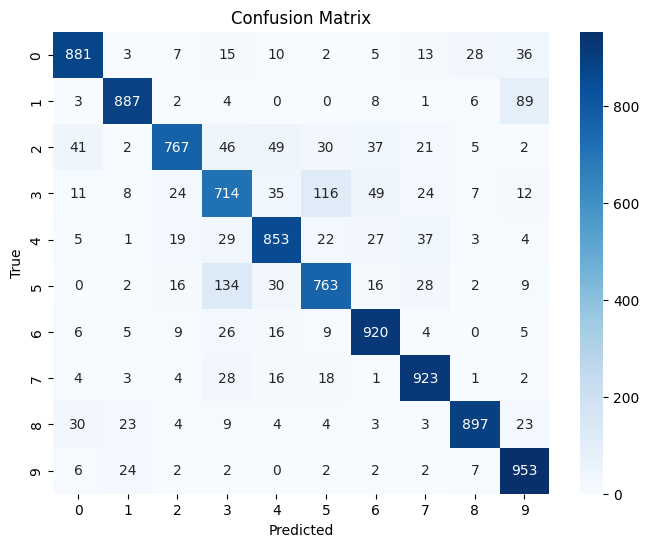

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## 2. Fine tuning (4 layers)

In [ ]:
vgg16_base_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

for layer in vgg16_base_model.layers:
    layer.trainable = False

for layer in vgg16_base_model.layers[-4:]:
    layer.trainable = True

vgg16_model_fine_tuned = keras.Sequential(
    [
        layers.Input(shape=input_shape),
        vgg16_base_model,
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ]
)

vgg16_model_fine_tuned.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
vgg16_model_fine_tuned.fit(x_train, y_train, epochs=30, batch_size=64, validation_split=.1)

## Conclusion

It seems that more layers or augmentation do not improve the result. It actually worsens it. 

Freezing the layers of the VGG16 model (down to 4), i.e. fine tuning, has drastically worsened the result.

Traning with a lower number of batches and more epochs has improved the result.

## Save our final model

The trained model is stored within an AWS S3 bucket:<br />
https://project-image-classification-models.s3.eu-central-1.amazonaws.com/vgg16_model.keras

In [7]:
vgg16_model.save("vgg16_model.keras")